In [13]:
import itertools
import random

import torch
from torch.nn import Linear
from torch.nn import functional as F
from torch.nn.functional import cosine_similarity
from torch.optim import Adam
from torch_geometric.data import Data
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, MessagePassing, TopKPooling
from torch_geometric.transforms import NormalizeFeatures
from torch_scatter import scatter_mean
from collections import defaultdict

from custom.args import grey, purple
from custom.dataset import GraphDataset, create_dataset
from custom.utils import *
from networkx.algorithms.centrality import degree_centrality
import pickle
from itertools import zip_longest

In [40]:
(graph1, graph2, attention_nodes) = torch.load("info.pt")

In [15]:
def print_attentions(attention_nodes, d):
    n_layers = len(attention_nodes)
    max_length = max(
        max(len(attn_1_to_2), len(attn_2_to_1))
        for attn_1_to_2, attn_2_to_1 in attention_nodes
    )

    col_width = 30

    if d == "12":
        print(" Graph 1 to Graph 2:".ljust(73))
    else:
        print(" Graph 2 to Graph 1:".ljust(73))
    print("=" * 130)

    for node_idx in range(max_length):
        line = []

        for layer_idx in range(n_layers):
            if d == "12":
                if node_idx < len(attention_nodes[layer_idx][0]):
                    attn_1_to_2 = attention_nodes[layer_idx][0][node_idx]
                    attn_1_to_2_str = f"{node_idx}: {attn_1_to_2}".ljust(col_width)
                else:
                    attn_1_to_2_str = "".ljust(col_width)

                line.append(attn_1_to_2_str)

            else:
                if node_idx < len(attention_nodes[layer_idx][1]):
                    attn_2_to_1 = attention_nodes[layer_idx][1][node_idx]
                    attn_2_to_1_str = f"{node_idx}: {attn_2_to_1}".ljust(col_width)
                else:
                    attn_2_to_1_str = "".ljust(col_width)

                line.append(attn_2_to_1_str)

        g1_to_g2_str = " | ".join(line)

        print(f"{g1_to_g2_str}")

    print("=" * 130)

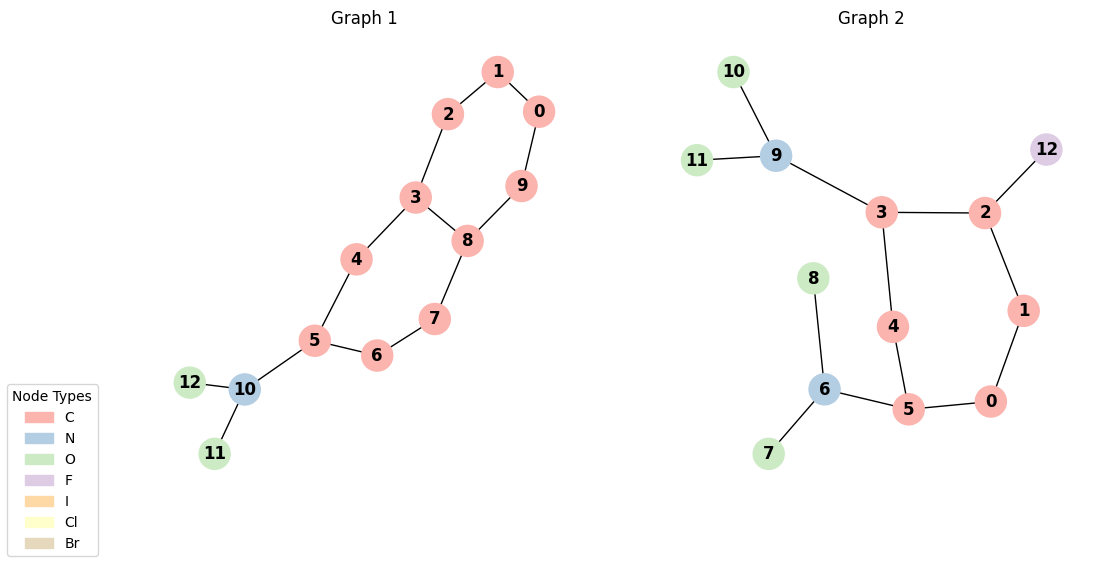

In [41]:
plot_mutag(graph1, graph2)

In [17]:
print_attentions(attention_nodes, d="12")

 Graph 1 to Graph 2:                                                     
0: [0, 1, 2, 3, 4, 5]          | 0: [0, 1, 4]                   | 0: [0, 1, 4, 12]              
1: [0, 1, 2, 3, 4, 5]          | 1: [0, 1, 4]                   | 1: [0, 1, 4, 12]              
2: [0, 1, 2, 3, 4, 5]          | 2: [0, 1, 4]                   | 2: [0, 1, 4, 12]              
3: [0, 1, 2, 3, 4, 5]          | 3: [2, 3, 5]                   | 3: [2, 3, 5]                  
4: [0, 1, 2, 3, 4, 5]          | 4: [0, 1, 4]                   | 4: [0, 1, 4, 12]              
5: [0, 1, 2, 3, 4, 5]          | 5: [2, 3, 5]                   | 5: [2, 3, 5]                  
6: [0, 1, 2, 3, 4, 5]          | 6: [0, 1, 4]                   | 6: [0, 1, 4, 12]              
7: [0, 1, 2, 3, 4, 5]          | 7: [0, 1, 4]                   | 7: [0, 1, 4, 12]              
8: [0, 1, 2, 3, 4, 5]          | 8: [2, 3, 5]                   | 8: [2, 3, 5]                  
9: [0, 1, 2, 3, 4, 5]          | 9: [0, 1, 4]        

In [18]:
print_attentions(attention_nodes, d="21")

 Graph 2 to Graph 1:                                                     
0: []                          | 0: [0, 1, 2, 4, 6, 7, 9]       | 0: [0, 1, 2, 4, 6, 7, 9]      
1: []                          | 1: [0, 1, 2, 4, 6, 7, 9]       | 1: [0, 1, 2, 6, 7, 9]         
2: []                          | 2: [3, 5, 8]                   | 2: [3, 5, 8]                  
3: []                          | 3: [3, 5, 8]                   | 3: [3, 5, 8]                  
4: []                          | 4: [0, 1, 2, 4, 6, 7, 9]       | 4: [2, 4, 6, 7, 9]            
5: []                          | 5: [3, 5, 8]                   | 5: [3, 5, 8, 10]              
6: [10]                        | 6: [10]                        | 6: [5, 10]                    
7: [11, 12]                    | 7: [11, 12]                    | 7: [11, 12]                   
8: [11, 12]                    | 8: [11, 12]                    | 8: [11, 12]                   
9: [10]                        | 9: [10]             

In [19]:
def mutual_pairs(attention_nodes, i=0):
    outer_layer = attention_nodes[i]
    g1_attention, g2_attention = outer_layer

    mutual_pairs = []

    for g1_node, g1_attends in enumerate(g1_attention):
        for g2_node in g1_attends:
            if g1_node in g2_attention[g2_node]:
                pair = (g1_node, g2_node)
                if pair not in mutual_pairs:
                    mutual_pairs.append(pair)

    return set(mutual_pairs)


pairs = mutual_pairs(attention_nodes)
print(pairs)

{(11, 7), (12, 11), (12, 7), (11, 10), (12, 10), (10, 6), (10, 9), (11, 8), (12, 8), (11, 11)}


In [48]:
def explore(graph1, graph2, attention_nodes):
    explored = set()
    patterns = []
    g1_explored, g2_explored = set(), set()

    # for i in range(len(attention_nodes)):
    for i in range(1):
        pairs = mutual_pairs(attention_nodes, i)

        def find_neigbors(graph, node):
            neighbors = graph.edge_index[1, graph.edge_index[0] == node].tolist()
            neighbors += graph.edge_index[0, graph.edge_index[1] == node].tolist()
            neighbors = list(set(neighbors))
            return neighbors

        def find_mutual_pair(g1_frontier, g2_frontier, mp, explored):
            mutual_pairs_set = set(mp)
            for node_g1 in g1_frontier:
                for node_g2 in g2_frontier:
                    if (node_g1, node_g2) in mutual_pairs_set:
                        if not (node_g1, node_g2) in explored:
                            return node_g1, node_g2
            return None

        for pair in pairs:
            if pair in explored:
                continue

            pattern = set()
            g1_frontier, g2_frontier = set(), set()

            # g1_explored.add(pair[0])
            # g2_explored.add(pair[1])

            g1_explored = set()
            g2_explored = set()

            n1 = pair[0]
            n2 = pair[1]
            pattern.add((n1, n2))

            explored.add(pair)
            g1_explored.add(n1)
            g2_explored.add(n2)

            while True:
                print(f"(n1, n2): ({n1, n2})")
                print(f"G1 frontier: {g1_frontier}")
                print(f"G2 frontier: {g2_frontier}")
                print(f"Pattern: {pattern}")

                g1_neighbors = set()
                g2_neighbors = set()
                for i in find_neigbors(graph1, n1):
                    if not i in g1_explored:
                        g1_frontier.add(i)
                        g1_neighbors.add(i)

                for i in find_neigbors(graph2, n2):
                    if not i in g2_explored:
                        g2_frontier.add(i)
                        g2_neighbors.add(i)

                print(f"  G1 neighbors: {g1_neighbors}")
                print(f"  G2 neighbors: {g2_neighbors}")

                if len(g1_frontier) == 0 and len(g2_frontier) == 0:
                    break

                # print(f"G1 frontier: {g1_frontier}")
                # print(f"G2 frontier: {g2_frontier}")
                # print(f"G1 explored: {g1_explored}")
                # print(f"G2 explored: {g2_explored}")
                # print(f"  Exploring ({n1, n2})")

                p = find_mutual_pair(g1_frontier, g2_frontier, pairs, explored)

                if p is None:
                    break
                else:
                    print(f"  Selected pair: {p}")
                    # print(f"G1 frontier: {g1_frontier}")
                    # print(f"G2 frontier: {g2_frontier}")
                    g1_frontier.remove(p[0])
                    g2_frontier.remove(p[1])
                    # print(f"G1 frontier: {g1_frontier}")
                    # print(f"G2 frontier: {g2_frontier}")
                    # pattern.add(p)
                    explored.add(p)
                    g1_explored.add(p[0])
                    g2_explored.add(p[1])
                    n1 = p[0]
                    n2 = p[1]
                    pattern.add((n1, n2))
                    print("-----------------")

            print("-------------------------------------------------------------")

            if len(pattern) > 2:
                patterns.append(pattern)

    for i in patterns:
        print(len(i))

    return patterns


explore(graph1, graph2, attention_nodes)

(n1, n2): ((11, 7))
G1 frontier: set()
G2 frontier: set()
Pattern: {(11, 7)}
  G1 neighbors: {10}
  G2 neighbors: {6}
  Selected pair: (10, 6)
-----------------
(n1, n2): ((10, 6))
G1 frontier: set()
G2 frontier: set()
Pattern: {(11, 7), (10, 6)}
  G1 neighbors: {12, 5}
  G2 neighbors: {8, 5}
  Selected pair: (12, 8)
-----------------
(n1, n2): ((12, 8))
G1 frontier: {5}
G2 frontier: {5}
Pattern: {(11, 7), (10, 6), (12, 8)}
  G1 neighbors: set()
  G2 neighbors: set()
-------------------------------------------------------------
(n1, n2): ((12, 11))
G1 frontier: set()
G2 frontier: set()
Pattern: {(12, 11)}
  G1 neighbors: {10}
  G2 neighbors: {9}
  Selected pair: (10, 9)
-----------------
(n1, n2): ((10, 9))
G1 frontier: set()
G2 frontier: set()
Pattern: {(10, 9), (12, 11)}
  G1 neighbors: {11, 5}
  G2 neighbors: {10, 3}
  Selected pair: (11, 10)
-----------------
(n1, n2): ((11, 10))
G1 frontier: {5}
G2 frontier: {3}
Pattern: {(10, 9), (12, 11), (11, 10)}
  G1 neighbors: set()
  G2 nei

[{(10, 6), (11, 7), (12, 8)}, {(10, 9), (11, 10), (12, 11)}]